<a href="https://colab.research.google.com/github/sriprad/DeepLearning/blob/master/BERT_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 13.8MB/s 
     |████████████████████████████████| 3.0MB 16.0MB/s 
     |████████████████████████████████| 890kB 29.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=f1dc1d91a9ee010cc0cc8e0aa1dbe9d66192b00ed41600735b92635ef5d60b99
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel , BertTokenizerFast


In [5]:
device = torch.device("cuda")

In [6]:
from google.colab import files
uploaded = files.upload()
import io


Saving spamdata_v2.csv to spamdata_v2.csv


In [7]:
df = pd.read_csv(io.BytesIO(uploaded['spamdata_v2.csv']))

In [8]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [12]:
train_text.shape
temp_text.shape
train_labels.shape
temp_labels.shape

(1672,)

In [13]:
#import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

In [16]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [15]:
#BERT Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [17]:
tokenizer

In [18]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [19]:
seq_len = [len(i.split()) for i in train_text]

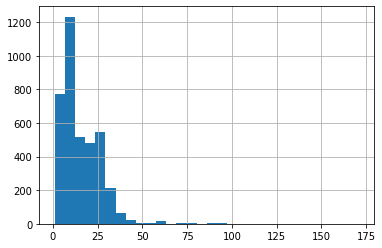

In [20]:
pd.Series(seq_len).hist(bins=30)

In [21]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [22]:
# convert lists to tensor
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [23]:
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [24]:
# create dataholders for both train and test data
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

#wrap tensors
train_data = TensorDataset(train_seq,train_mask,train_y)

#sampler for sampling during training
train_sampler = RandomSampler(train_data)

#dataloader for train dataset
train_dataloader = DataLoader(train_data,sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [25]:
# freeze all the parameters
for param in bert.parameters():
  param.requires_grad=False


In [26]:
#model architecture
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [27]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [28]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [29]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.57743559 3.72848948]


In [30]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [31]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [32]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [33]:
#fine tuning the model
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.687
Validation Loss: 0.662

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.646
Validation Loss: 0.628

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.619
Validation Loss: 0.599

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.596
Validation Loss: 0.573

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.573
Validation Loss: 0.547

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.548
Validation Loss: 0.526

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.530
Validation Loss: 0.504

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.513
Validat

In [34]:
#Make predictions

#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [35]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       724
           1       0.43      0.87      0.58       112

    accuracy                           0.83       836
   macro avg       0.70      0.85      0.74       836
weighted avg       0.90      0.83      0.85       836

